### Load downsampled annotation file and identify location

Major May 2022 update! 

Associated each point with an atlas ID based on full allen brain atlas directly fetched from allenSDK
(split to left and right hemisphere for axons)

Project downsampled points in to tiff file for illustration purposes (ie, can overlay to brain image stack or template stack)

Plot as bar graph

Plot as full resolution 3D scatter plot with hover region name

In [2]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import skimage
from skimage import io

import random

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

import Neuron_analysis as na
from Neuron_analysis import *

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache


In [ ]:
points_name=fdialog.askopenfile( title='Select the downsampled axon points').name
outdir = fdialog.askdirectory(title='Please select the output directory')


mcc = MouseConnectivityCache(resolution=25)

annot, annot_info = mcc.get_annotation_volume()

In [ ]:
print('Coronal atlas has shape', annot.shape)

annot_h=np.moveaxis(annot, 2, 0) #reslice corontal atlas to horizontal atlas
print('Converted to horizontal atlas with shape', annot_h.shape)

plt.imshow(annot_h[:,:,36], interpolation='nearest', vmin=0, vmax=3000)
plt.show()
# although in this plot it looks like the image should rotate 90 degrees to the right but it actually matches the dimension of image

In [ ]:
# Load the csv file containing the labels
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')
mouse_name= na.find_mousename(points_name)

out_name= os.path.join(outdir,mouse_name)

out_name

In [ ]:
def get_pt_natlas(dspoint_name, to_add):
    '''Read downsampled points after Transformix transformation onto
        Allen Atlas domain
    Feb 2022
        Modified for viral images where points are indices after trailmap segmentation with probability 
        Since some noise will be picked up as axons and cross probability threshold, it is possible for transformed points to have negative value or outside of the brain
        points with negative values any one dimensions are ignored
    Apr 2022
        Modified to not include atlas name
        Prefer to select atlas directly
    '''
    with open(dspoint_name,'r') as output:
        outputpoint= output.readlines()
    
    all_points=[]

    for lines in tqdm(outputpoint):
        m=re.search("(?:OutputIndexFixed = \[ )([0-9]+ [0-9]+ [0-9]+)", lines)
        if not m:
            print('negative number in one of the dimension, skipped')
            print(f'{lines}')
            pass
        else:
            m=m.groups(0)
            this_line= str(m[0]).split(' ')
            mypoints= [int(stuff) for stuff in this_line]
            mypoints[1]= mypoints[1]+to_add
            all_points.append(mypoints)
    
    return all_points


def make_tif(all_points, atlas_shape, outname):
    ''' Project downsampled points on to a tif stack, useful for overlaping with brain or template (ie, in imageJ)
    input: downsampled points in a list containing x y z ordinates as int, directory containing it (this is also the output directory) and whether annotation is axon or not (default True)
    example: [[12, 13, 25],
             [13, 14, 25],...]
    
    output: a tiff stack with the same dimensions of the template/atlas mhd files with downsampled points only
    each point has a value of the number of occurences (since downsampling combines multiple points as one)
    '''
        
    print('Starting to saving tif files..')
    
    svolume=np.zeros(atlas_shape)
    #columns, rows, planes

    zplanes=[]
    for i in all_points:
        zplanes.append( i[2])
    zplanes=np.unique(zplanes)
    temp=np.zeros(atlas_shape[0:2])
    thepoints=np.asarray(all_points)

    for i in zplanes:
        index= thepoints[:,2]==i
        uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
        for j, lines in enumerate(uindex):
            coord1,coord2=lines[0:2]
            temp[coord1][coord2]= counts[j]
        svolume[:,:,i]=temp #write this in 
        temp=np.zeros(atlas_shape[0:2]) #reset the empty plane after each z


    coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
    #for some reason, if just save stuff as tiff, it will save x planes of yz view
    #here we shift the 3rd dimension with the first dimension to obtain xy view

    io.imsave(outname,coronal_planetmp)
    return 

def find_points_id(points):
    points_in_atlas=[int(annot_h[i[0], i[1],i[2]]) for i in points]
    
    points_in_atlas= np.where(points_in_atlas==0, 981, points_in_atlas) 
    # replace id= 0 with 981 (ssp-bfd layer1)

    points_in_atlas= np.where(points_in_atlas==484682520, 484682528 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==484682524, 484682528 , points_in_atlas)
    
    # replace id= 484682520 (optic radiation)  and id= 484682524 (auditory radiation) with 484682258, stc(a subregion of fiber bundle)
    # these are intrinsic issue of the allen atlas, the labels for these regions are wrong
    
    points_in_atlas= np.where(points_in_atlas==382, 484682528 , points_in_atlas)
    # replace id= 382, hippocampus CA1 with 484682258, stc(a subregion of fiber bundle), to correct for slight misalignment with atlas
    
    points_in_atlas= np.where(points_in_atlas==81 , 672 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==98 , 672 , points_in_atlas)
    # replace id= 98 (subependymal zone) and 81 (lateral ventricle) with 215(caudoputamen), to correct for slight misalignment with atlas
    
    points_in_atlas= np.where(points_in_atlas==0, 981, points_in_atlas) 
    # somehow this line needs to be ran twice??
    return points_in_atlas

def regions_csv(points_in_atlas, out_name):

    unique_id, counts = np.unique(points_in_atlas, return_counts=True)
    id_withcounts=list(zip(unique_id, counts))

    our_regions=na.atlas_labels.loc[na.atlas_labels['id'].isin (unique_id)]

    new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
    our_regionWcounts=pd.merge(na.atlas_labels, new_df)
    
    our_regionWcounts.to_excel(out_name+'region_with_counts.xlsx',index=None,header=True)

    return our_regionWcounts

def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'counts': grouped_pd.counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['counts'], ascending=True, inplace=True)
    # result is the final pd

    return result

In [ ]:
# refill y section

all_points=get_pt_natlas(points_name,65)

In [ ]:
#make_tif(all_points,annot_h.shape,out_name+'_axons.tif') #Projects the points in the atlas space for visualization /verification purposes

In [ ]:
# Identify left and right hemisphere by splitting x in half
left_points= []
right_points= []
for item in all_points:
    if item[0]<227:
        left_points.append(item)
    else:
        right_points.append(item)

In [ ]:
#len(right_points)

In [ ]:
points_in_atlasR= find_points_id(right_points)
regionsR= regions_csv(points_in_atlasR,out_name+'_axon_right_')

points_in_atlasL= find_points_id(left_points)
regionsL= regions_csv(points_in_atlasL,out_name+'_axon_left_')

In [ ]:
regionsL.head()

In [ ]:
regionsR.head()

In [ ]:
#dendrites= readandrefill(Dpoints_name,to_add)

In [ ]:
#make_tif(dendrites,annot_h.shape,out_name+'_dendrites.tif')

In [ ]:
# points_in_atlasD= find_points_id(dendrites)
# regionsD= regions_csv(points_in_atlasD,out_name+'_dendrites_')

In [ ]:
# regionsD

In [ ]:
# Generate excel file of regions in parent name (1 graph order up) for each hemisphere
axon_subL=regionsL.sort_values(by=['counts'])
axon_subL.sort_values(by= 'graph_order',axis=0, inplace=True)
parentL= parent_df(axon_subL)
parentL.sort_values('counts',ascending=False, inplace=True)

parentL.to_excel(f'{out_name}_Lparent.xlsx') 

In [ ]:
# Generate excel file of regions in parent name (1 graph order up) for each hemisphere

axon_subR=regionsR.sort_values(by=['counts'])
axon_subR.sort_values(by= 'graph_order',axis=0, inplace=True)
parentR= parent_df(axon_subR)

parentR.sort_values('counts',ascending=False, inplace=True)

parentR.to_excel(f'{out_name}_Rparent.xlsx') 

## Plotting section- bar graphs

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
def arrange_parent_subregion(parentdf,subregiondf):
    new_order=parentdf.id.to_numpy()
    
    old_order= subregiondf.parent_structure_id.to_numpy()   
    
    print('Old parent region id order is: ', old_order)
    print('New parent region id order is: ', new_order)
    
    
    new_array= np.zeros_like(old_order)
    for i, j in enumerate(new_order):
        new_array[old_order==j]=i
        
    print('Re-arranged subregion order based on parent region that has the greatest number of axon: ', new_array)
    
    subregiondf['new_order']= new_array
    subregiondf.sort_values('new_order', inplace=True)
    
    subregiondf.sort_values(by=['new_order', 'graph_order'], ascending=[True, True] ,inplace=True)

    return subregiondf

def plot_hist(pd_axonL,pd_axonR, out_name):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''

    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=1,
        row_heights=[0.6, 0.5],
        row_titles=['Left axons', 'Right axons', 'Dendrites']
    )
    
    fig.add_trace(
        go.Bar(
        y=pd_axonL['acronym'], x=pd_axonL['counts']/1000, # units now in milimeters
        marker_color='red', #for future, pd_axon['region_id'],
        name='',
        text=pd_axonL['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    
    fig.add_trace(
        go.Bar(
        y=pd_axonR['acronym'], x=pd_axonR['counts']/1000, # units now in milimeters
        marker_color='magenta', #for future, pd_axon['region_id'],
        name='',
        text=pd_axonR['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )
    

   
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      width=2000,
                      height=1000, # 1500 for AL066 since too many items
                      showlegend= False,
                      paper_bgcolor='rgba(0,0,0,0)', # transparent background
                      plot_bgcolor='rgba(0,0,0,0)' # transparent background
                     )
    
    fig.update_xaxes(gridcolor='gold')
    
    fig.show()

    fig.write_image(f"{out_name}.svg")
    fig.write_html(f"{out_name}.html")

In [ ]:

print('For left hemisphere')
new_axonL= arrange_parent_subregion(parentL,axon_subL)

print('For right hemisphere')
new_axonR= arrange_parent_subregion(parentR,axon_subR)


In [ ]:
plot_hist(parentL,parentR,out_name+'parent')

In [ ]:
plot_hist(new_axonL,new_axonR,out_name)

## Plot summary heatmaps 

In [6]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

In [ ]:
#find all relevant files
folder= outdir = fdialog.askdirectory(title='Select folder containing parent informations')

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]
#change to Rparent for the other hemisphere!

In [ ]:
parent_axons

In [ ]:
axonal_df= combine_df(folder, parent_axons)
# keep Nan for heatmap display purposes

In [ ]:
final=axonal_df.T
final

In [ ]:
x=final.columns.to_list()
y=final.index.to_list()

full_name=[]
for i in y:
    name=na.atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)
# get full name

In [ ]:
#factor = 5
#new_list = [entry for entry in full_name for _ in range(factor)]
# repeat each anatomical region-s full name for 5 times(ie. the number of animal) in preparation for hover information
# nice code but need list of 5 reptitions as it own list withina  big list..

In [ ]:
#prepare for hovertext
new_list=[]

for item in full_name:
    small_list= [item] *5
    new_list.append(small_list)

In [86]:
import plotly.figure_factory as ff

In [ ]:
fig = ff.create_annotated_heatmap(z=final.values, 
                                  colorscale='Portland',
                                  font_colors=['white'],
                                  zmax= 10000,
                                  zmin=100,
                                  y=y,
                                  x=x,
                                  hoverongaps = False,
                                  hovertext=new_list
                                 )
fig.update_xaxes(visible=True, showgrid=False)
fig.update_yaxes(visible=True, showgrid=False)

fig.update_layout(
    width = 1500, height = 8000,
    autosize = True,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)


fig.show()

#fig.write_image(f"{folder}/summary.svg")
fig.write_html(f"{folder}/summary_left.html")

### Section 2 pearsons correlation matrix

In [71]:
import plotly.graph_objects as go


In [13]:
indir = fdialog.askdirectory(title='Please select the input directory')

outdir = fdialog.askdirectory(title='Please select the output directory')


In [122]:
def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_csv(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def plot_corr(df,outname='', save= False):
    '''Plot correlation matrix as annotated heatmap'''
    
    z=np.round(df.values,2)
    x=list(df.index)
    
    fig = ff.create_annotated_heatmap(z=z, x=x, y=x, colorscale='Jet')
    fig.update_xaxes(visible=True, showgrid=False)
    fig.update_yaxes(visible=True, showgrid=False)

    fig.update_layout(
        autosize = True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )


    fig.show()
    
    if save== True:
        fig.write_html(f"{outname}.html")
    else:
        pass


In [138]:
parent_axons= [ i for i  in os.listdir(indir) if 'Lparent' in i]
#parent_axons
axonal_df= combine_df(indir, parent_axons)
axonal_df.fillna(0, inplace=True)

axonal_corr=axonal_df.T.corr()
axonal_corr
#plot_corr(axonal_corr)
#correlation based on left-parent region

,AL207,AL210,AL213,AL215,AL257
AL207,1.000000,0.498012,0.533756,0.606216,0.405222
AL210,0.498012,1.000000,0.960444,0.921061,0.913404
AL213,0.533756,0.960444,1.000000,0.969872,0.952372
AL215,0.606216,0.921061,0.969872,1.000000,0.929676
AL257,0.405222,0.913404,0.952372,0.929676,1.000000


In [139]:
parent_axons_R= [ i for i  in os.listdir(indir) if 'Rparent' in i]
axonal_df_R= combine_df(indir, parent_axons_R)
axonal_df_R.fillna(0, inplace=True)
axonal_Rcorr=axonal_df_R.T.corr()

axonal_Rcorr
#plot_corr(axonal_Rcorr)
#correlation based on right-parent region

,AL207,AL210,AL213,AL215,AL257
AL207,1.000000,-0.037937,0.088913,0.148248,-0.048939
AL210,-0.037937,1.000000,0.663973,0.781768,0.322697
AL213,0.088913,0.663973,1.000000,0.904587,0.508973
AL215,0.148248,0.781768,0.904587,1.000000,0.411929
AL257,-0.048939,0.322697,0.508973,0.411929,1.000000


In [140]:
full_df=axonal_df.add(axonal_df_R, fill_value=0)
full_corr=full_df.T.corr()

full_corr
#plot_corr(full_corr)
#correlation based on both hemispheres-parent region

,AL207,AL210,AL213,AL215,AL257
AL207,1.000000,0.526867,0.540056,0.623850,0.433507
AL210,0.526867,1.000000,0.943277,0.923173,0.881144
AL213,0.540056,0.943277,1.000000,0.980285,0.954251
AL215,0.623850,0.923173,0.980285,1.000000,0.932353
AL257,0.433507,0.881144,0.954251,0.932353,1.000000


In [ ]:
# Now lets see if subregions makes more difference, maybe should do correlation with full list of subregions instead of parents

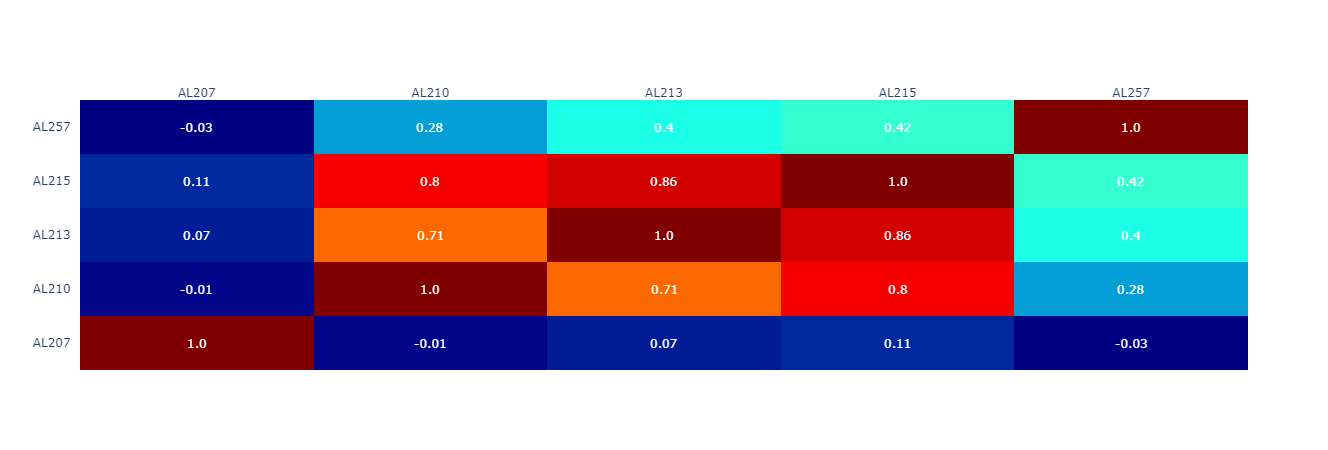

In [136]:
sub_axons_R= [ i for i  in os.listdir(indir) if 'axon_right' in i]
sub_df_R= combine_df(indir, sub_axons_R)
sub_df_R.fillna(0, inplace=True)

sub_Rcorr=sub_df_R.T.corr()
plot_corr(sub_Rcorr,outname=f'{outdir}\\Right_subregions', save=True)

#correlation based on Right subregions

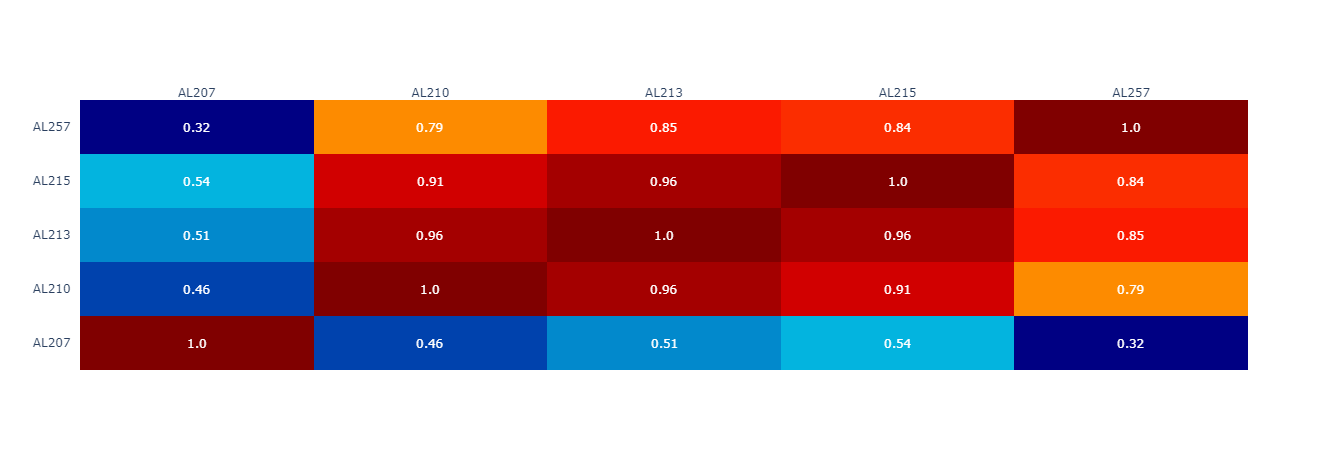

In [137]:
sub_axons_L= [ i for i  in os.listdir(indir) if 'axon_left' in i]
sub_df_L= combine_df(indir, sub_axons_L)
sub_df_L.fillna(0, inplace=True)
sub_Lcorr=sub_df_L.T.corr()
plot_corr(sub_Lcorr,outname=f'{outdir}\\left_subregions', save=True)

#correlation based on left subregions

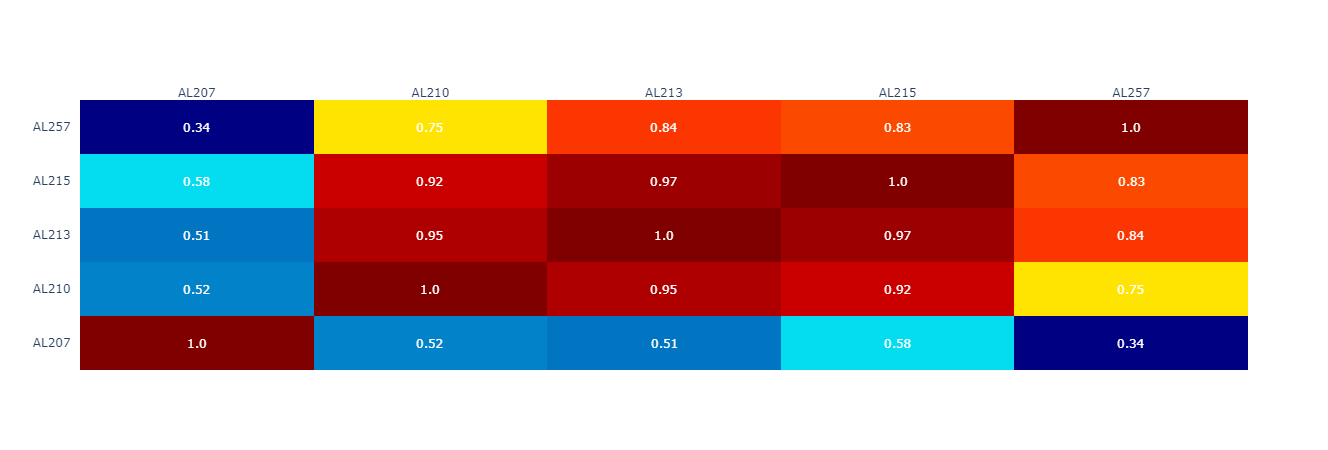

In [133]:
sub_df=sub_df_L.add(sub_df_R, fill_value=0)

sub_corr=sub_df.T.corr()
plot_corr(sub_corr,outname=f'{outdir}\\fullbrain_subregions', save=True)
          
#correlation based on both

In [30]:
#work in progress for future!
# UMMM Maybe I should remove those impossible locations such as ventricular systems and hippocampus in the future??
y=axonal_df.T.index.to_list()

full_name=[]
for i in y:
    name=na.atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)
# get full name

